Обучить модель семантической сегментации (человек-vs-фон) на подмножестве датасета MS COCO
Библиотеки: [Python, Tensorflow]

In [ ]:
%tensorflow_version 2.x

In [ ]:
import os
import skimage.io as io
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

Загрузка датасета COCO и COCO API

In [ ]:
if 1:
    !mkdir -p data

    !cd data && wget http://images.cocodataset.org/zips/train2017.zip 
    !cd data && wget http://images.cocodataset.org/zips/val2017.zip 
    !cd data && wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip 

    !cd data && unzip -q train2017.zip
    !cd data && unzip -q val2017.zip
    !cd data && unzip -q annotations_trainval2017.zip

    !cd data && git clone https://github.com/cocodataset/cocoapi
    !cd data/cocoapi/PythonAPI && make

--2022-07-23 11:43:32--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.105.139
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.105.139|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  74.0MB/s    in 4m 21s  

2022-07-23 11:47:53 (70.6 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]

--2022-07-23 11:47:54--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.139.67
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.139.67|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  68.6MB/s    in 9.7s    

2022-07-23 11:48:04 (79.9 MB/s) - 

In [ ]:
COCO_ROOT = './data/'
import sys
sys.path.insert(0, os.path.join(COCO_ROOT, 'cocoapi/PythonAPI'))
from pycocotools.coco import COCO

Универсальный класс Dataset для сегментации



In [ ]:
class Dataset():

    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)

        if random_crop:
            img = tf.image.random_crop(img, (inp_size, inp_size, shape[2]))
        else: # central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :]

        return img

    def train_dataset(self, batch_size, epochs, inp_size):

        def item_to_images(item):
            random_crop = True
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        dataset = dataset.map(item_to_images)
        dataset = dataset.repeat(epochs)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

    def val_dataset(self, batch_size, inp_size):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

Класс для сегментационного датасета COCO

In [ ]:
class COCO_Dataset(Dataset):

    def __init__(self, sublist):
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['person'])
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)

    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)

        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)

        return img_combined

In [ ]:
COCO_dataset_train = COCO_Dataset('train')
COCO_dataset_val = COCO_Dataset('val')

loading annotations into memory...
Done (t=19.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.61s)
creating index...
index created!


In [ ]:
COCO_dataset_train

In [ ]:
INP_SIZE = 256
NUM_EPOCHS = 1
BATCH_SIZE = 32
train_ds = COCO_dataset_train.train_dataset(batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, inp_size=INP_SIZE)
test_ds = COCO_dataset_val.val_dataset(batch_size=BATCH_SIZE, inp_size=INP_SIZE)

In [ ]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(32, 256, 256, None), dtype=tf.float32, name=None), TensorSpec(shape=(32, 256, 256, None), dtype=tf.float32, name=None))>

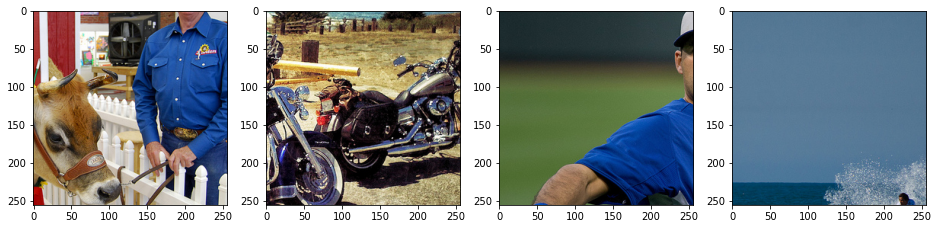

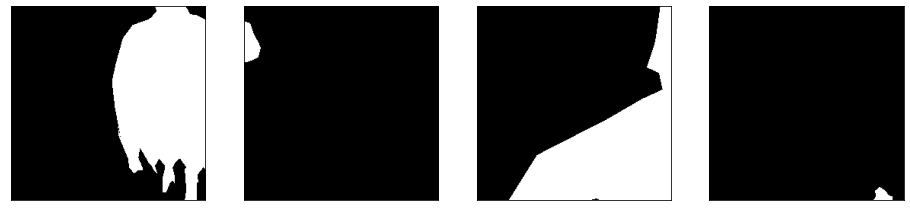

In [ ]:
some_samples = [x for x in iter(train_ds.take(4))]

fig = plt.figure(figsize=(16, 16))
for i in range(len(some_samples)):
    ax1 = fig.add_subplot(1, 4, i+1)
    # print(some_samples[i][0].shape)
    # print(some_samples[i][1].shape)
    ax1.imshow(some_samples[i][0][0])

fig = plt.figure(figsize=(16, 16))
for i in range(len(some_samples)):
    ax2 = fig.add_subplot(1, 4, i+1)
    ax2.imshow(some_samples[i][1][0].numpy().reshape(256, 256), cmap='gray')
    plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
import random
import imageio
import numpy as np

Создание модели U-Net

In [ ]:
# U-Net
def build_model():
    x = tf.keras.layers.Input((256, 256, 3))
    
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    out1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out1)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out2 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out2)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out3 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out3)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out4 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out4)

    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out4, out], axis=3)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out3, out], axis=3)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out2, out], axis=3)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out1, out], axis=3)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(out)

    return tf.keras.Model(inputs=x, outputs=out)

model = build_model()

Визуализация U-Net

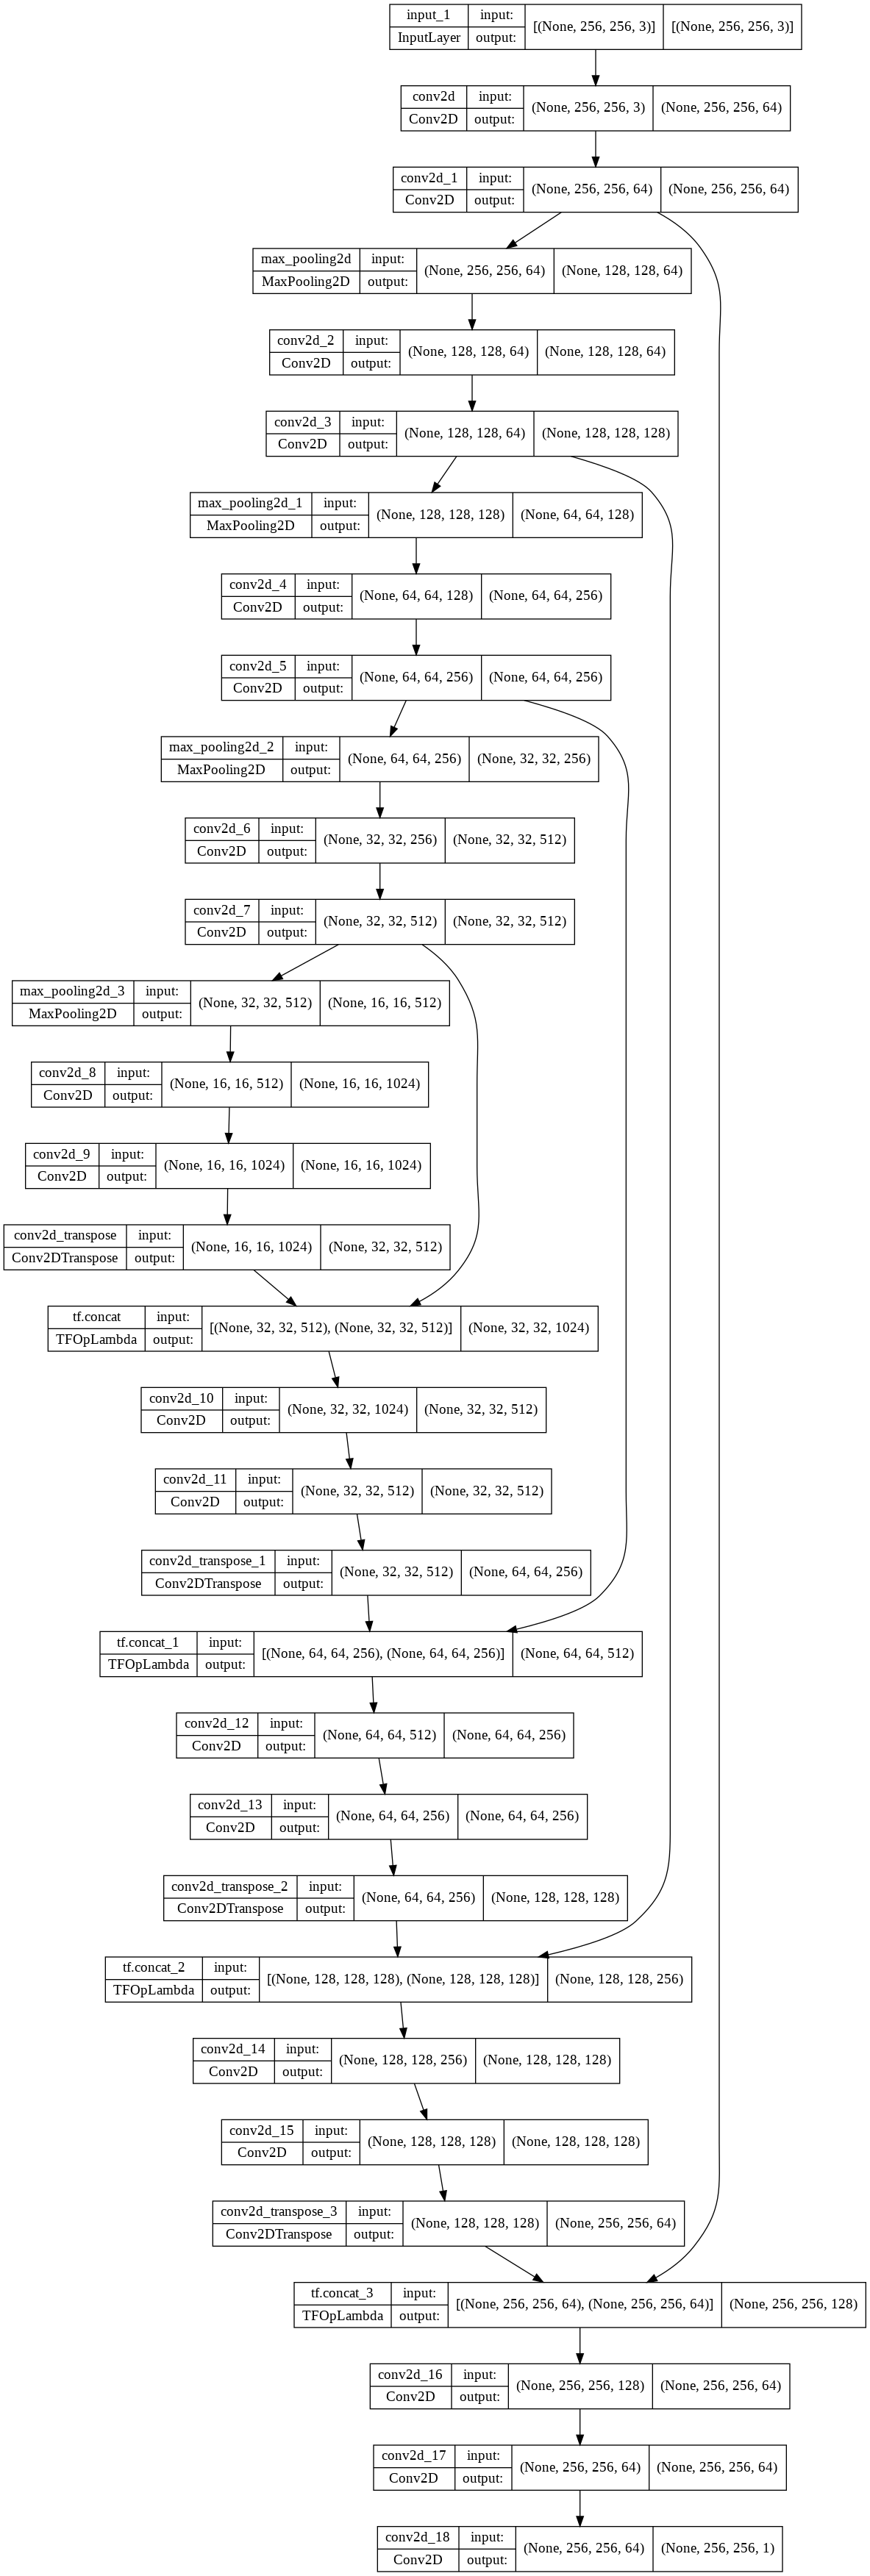

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Обучение модели

In [ ]:
NUM_EPOCHS = 1
BATCH_SIZE = 32

loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer='adam', loss=loss)

hist = model.fit(train_ds, epochs=NUM_EPOCHS)

Пример результата сегментации

In [ ]:
model.evaluate(test_ds)

In [ ]:
prediction = model.predict(test_ds)

In [ ]:
plt.imshow(prediction[0].reshape(256, 256), cmap='gray')
plt.show()